In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
ls

 class_masks/                           LICENSE        Report.pdf
 compare_pred_to_gt/                    main_unet.py   requirements.txt
 Comparison_Test.pdf                   'New folder'/   test_outputs/
 _config.yml                            plots/         test_unet.py
 confusion_matrices_train_and_val.txt   plots.png      train_predictions/
 images_for_doc/                        PSPNet/        unet.py
 Inter-IIT-CSRE/                        pywin-0.3.1/   Untitled.ipynb
 iou.py                                 README.md


In [4]:
!pip install numpy==1.19.2
!pip install scipy==1.1.0

     |████████████████████████████████| 14.5MB 243kB/s 
ERROR: tensorflow 2.3.0 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.2 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5


     |████████████████████████████████| 31.2MB 107kB/s 
ERROR: umap-learn 0.4.6 has requirement scipy>=1.3.1, but you'll have scipy 1.1.0 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.2 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement scipy==1.4.1, but you'll have scipy 1.1.0 which is incompatible.
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


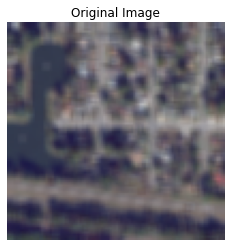

iter: 1, time interval: 0:0:1:566314
iter: 2, time interval: 0:0:1:651984
iter: 3, time interval: 0:0:1:629129
iter: 4, time interval: 0:0:1:649119
iter: 5, time interval: 0:0:1:587304
iter: 6, time interval: 0:0:1:635714
iter: 7, time interval: 0:0:1:626268
iter: 8, time interval: 0:0:1:614054
iter: 9, time interval: 0:0:1:607549
iter: 10, time interval: 0:0:1:585231
iter: 11, time interval: 0:0:1:625551
iter: 12, time interval: 0:0:1:577164
iter: 13, time interval: 0:0:1:668238
iter: 14, time interval: 0:0:1:628919
iter: 15, time interval: 0:0:1:664291
iter: 16, time interval: 0:0:1:587531
iter: 17, time interval: 0:0:1:601049
iter: 18, time interval: 0:0:1:627781
iter: 19, time interval: 0:0:1:573241
iter: 20, time interval: 0:0:1:634460
iter: 21, time interval: 0:0:1:592613
iter: 22, time interval: 0:0:1:606814
iter: 23, time interval: 0:0:1:593422
iter: 24, time interval: 0:0:1:615581
iter: 25, time interval: 0:0:1:627808
iter: 26, time interval: 0:0:1:675055
iter: 27, time interv

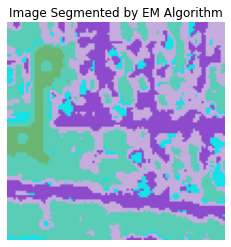

In [6]:
import datetime
from dateutil.relativedelta import relativedelta

import numpy as np
import scipy.stats
import math
import cv2
from scipy import ndimage

from sklearn import cluster
from scipy.cluster.vq import kmeans2
import matplotlib.pyplot as plt
from scipy import ndimage


# input fllename >> output 3d array
def read_img(filename):
    img_3d = ndimage.imread(filename)

    small = cv2.resize(img_3d, (0, 0), fx=0.1, fy=0.1)
    blur = cv2.blur(small, (4, 4))
    return blur


# input 3d array >> output 2d array
def flatten_img(img_3d):
    x, y, z = img_3d.shape
    img_2d = img_3d.reshape(x*y, z)
    img_2d = np.array(img_2d, dtype = np.float)
    return img_2d


# input 2d array >> output 3d array
def recover_img(img_2d, vis = False, X=80, Y=80, Z=3):
    #img_2d = cv2.resize(img_2d, (0, 0), fx=10, fy=10)
    img_2d = (img_2d * 255).astype(np.uint8)
    recover_img = img_2d.reshape(X, Y, Z)
    return recover_img


# input 2d array >> output estimated means, stds, pis
def kmeans_init(img, k):
    means, labels = kmeans2(img, k)
    try:
        means = np.array(means)
        cov = np.array([np.cov(img[labels == i].T) for i in range(k)])
        ids = set(labels)
        pis = np.array([np.sum([labels == i]) / len(labels) for i in ids])
    except Exception as ex:
        pass
    return means, cov, pis


# E-Step: Update Parameters
# update the conditional pdf - prob that pixel i given class j
def update_responsibility(img, means, cov, pis, k):
    # responsibilities: i th pixels, j th class
    # pis * gaussian.pdf
    responsibilities = np.array([pis[j] * scipy.stats.multivariate_normal.pdf(img, mean=means[j], cov=cov[j]) for j in range(k)]).T
    # normalize for each row
    norm = np.sum(responsibilities, axis = 1)
    # convert to column vector
    norm = np.reshape(norm, (len(norm), 1))
    responsibilities = responsibilities / norm
    return responsibilities


# update pi for each class of Gaussian model
def update_pis(responsibilities):
    pis = np.sum(responsibilities, axis = 0) / responsibilities.shape[0]
    return pis


# update means for each class of Gaussian model
def update_means(img, responsibilities):
    means = []
    class_n = responsibilities.shape[1]
    for j in range(class_n):
        weight = responsibilities[:, j] / np.sum(responsibilities[:, j])
        weight = np.reshape(weight, (1, len(weight)))
        means_j = weight.dot(img)
        means.append(means_j[0])
    means = np.array(means)
    return means


# update covariance matrix for each class of Gaussian model
def update_covariance(img, responsibilities, means):
    cov = []
    class_n = responsibilities.shape[1]
    for j in range(class_n):
        weight = responsibilities[:, j] / np.sum(responsibilities[:, j])
        weight = np.reshape(weight, (1, len(weight)))
        # Each pixels have a covariance matrice
        covs = [np.mat(i - means[j]).T * np.mat(i - means[j]) for i in img]
        # Weighted sum of covariance matrices
        cov_j = sum(weight[0][i] * covs[i] for i in range(len(weight[0])))
        cov.append(cov_j)
    cov = np.array(cov)
    return cov


# M-step: choose a label that maximise the likelihood
def update_labels(responsibilities):
    labels = np.argmax(responsibilities, axis = 1)
    return labels


def update_loglikelihood(img, means, cov, pis, k):
    pdf = np.array([pis[j] * scipy.stats.multivariate_normal.pdf(img, mean=means[j], cov=cov[j]) for j in range(k)])
    log_ll = np.log(np.sum(pdf, axis = 0))
    log_ll_sum = np.sum(log_ll)
    return log_ll_sum


def EM_cluster(img, k, error = 10e-4, iter_n = 100):
    #  init setting
    cnt = 0
    likelihood_arr = []
    # Initialise E-Step by KMeans
    means, cov, pis = kmeans_init(img, k)
    likelihood = 0
    new_likelihood = 2
    responsibilities = update_responsibility(img, means, cov, pis, k)
    while (abs(likelihood - new_likelihood) > error) and (cnt != iter_n):
        start_dt = datetime.datetime.now()
        cnt += 1
        likelihood = new_likelihood
        # M-Step
        labels = update_labels(responsibilities)
        # E-step
        responsibilities = update_responsibility(img, means, cov, pis, k)
        means = update_means(img, responsibilities)
        cov = update_covariance(img, responsibilities, means)
        pis = update_pis(responsibilities)
        new_likelihood = update_loglikelihood(img, means, cov, pis, k)
        likelihood_arr.append(new_likelihood)
        end_dt = datetime.datetime.now()
        diff = relativedelta(end_dt, start_dt)
        print("iter: %s, time interval: %s:%s:%s:%s" % (cnt, diff.hours, diff.minutes, diff.seconds, diff.microseconds))
    likelihood_arr = np.array(likelihood_arr)
    print('Converge at iteration {}'.format(cnt + 1))
    return labels, means, cov, pis, likelihood_arr


def main():
    FILENAME1 = 'Inter-IIT-CSRE/The-Eye-in-the-Sky-dataset/sat/JAX_004_006_RGB.tif'
    try:
        orig_img = read_img(FILENAME1)
        x, y, z = orig_img.shape
        plt.figure()
        plt.axis("off")
        plt.imshow(orig_img)
        plt.title('Original Image');
        plt.show()

        img = flatten_img(orig_img)
        labels, means, cov, pis, likelihood_arr = EM_cluster(img, 5)
        em_img = recover_img(means[labels], X=x, Y=y, Z=z)
        plt.figure()
        plt.axis("off")
        plt.imshow(em_img)
        plt.title('Image Segmented by EM Algorithm');
        plt.show()
    except Exception as ex:
        print(ex)


main()